In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wave_net import WaveNet
from wave_net_utils import load_voices_files, get_max_length,fill_voices_data_with_pads, quantize_voices, get_voices_labels,load_train_data, batch_iter_to_queue
from multiprocessing import Process, Queue

model = WaveNet(layers=30, residual_channels=512, layer_channels=256, kernel_size=3, skip_channels=256, aggregate_channels=256)
model.train()
# device = torch.device("cuda:0")
device = torch.device("cpu") 
print('use device: %s' % device, file=sys.stderr)
model = model.to(device)



use device: cpu


In [2]:

clip_size=7680
train_records = 1000
epoch_size = 256
train_batch_size = 4
max_epoch = 10
log_iter = 1

data_queue = Queue(1)
batch_queue = Queue(1)
loss_queue = Queue(2)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0002)


train_data_to_queue_process = Process(target=load_train_data, args=('dataset/train', train_records, epoch_size, data_queue, clip_size,10))
train_data_to_queue_process.start()

batch_iter_to_queue_process = Process(target=batch_iter_to_queue, args=(data_queue, batch_queue, loss_queue, max_epoch, train_batch_size, True))
batch_iter_to_queue_process.start()
print("start training...")

epoch, batch_data = batch_queue.get(True)
iter = 0
while batch_data is not None :
    optimizer.zero_grad()
    # forward + backward + optimize

    batch_data = get_voices_labels(batch_data)
    # print("labels.shape:", labels.shape)
    labels = torch.tensor(batch_data[:,1:]).long().to(device)
    inputs = np.array(batch_data[:,:-1])/(256/2)
    # print("input.shape:", inputs.shape)
    if inputs.shape[0] == 0: 
      epoch, batch_data = batch_queue.get(True)
      continue
    outputs = model(inputs, None)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()  
    iter += 1
    batch_loss = loss.item()/len(batch_data)
    if iter % log_iter == 0:
      print('epoch: [%d] iter: [%d] loss: %.3f' % (epoch, iter, batch_loss))
    loss_queue.put(batch_loss, True)
    epoch, batch_data = batch_queue.get(True)

print("training end.")
train_data_to_queue_process.join()
batch_iter_to_queue_process.join()



loading train data ...
remaining train data length: 0
geting train data ...
pushing new round train data: 0
start new training 1: data(size = 267) in 10 epoches : ...
start training...


RuntimeError: Given groups=1, weight of size [256, 256, 1], expected input[4, 512, 7679] to have 256 channels, but got 512 channels instead

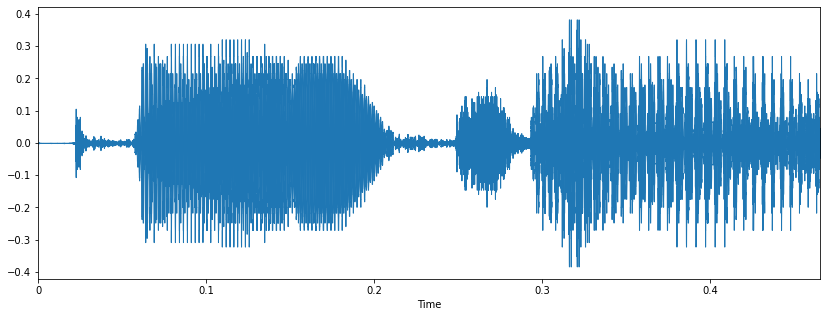

In [27]:
%matplotlib inline
# https://musicinformationretrieval.com/ipython_audio.html
# https://github.com/librosa/tutorial/blob/master/Librosa%20tutorial.ipynb

# voices=load_voices_files(['dataset/dev/LJ050-0274.wav'])
voices=load_voices_files(['dataset/train/LJ001-0001.wav'])

voices = np.array(voices)/(65536/2)

plt.figure(figsize=(14, 5))
outputs = model(voices[:, :10*1024], None)
reconstructed_voices = model.reconstruct_from_output(outputs)
# reconstructed_voices = reconstructed_voices / (65,536/2)
x = reconstructed_voices[0].cpu().detach().numpy()

librosa.display.waveplot(x, sr=22000)
ipd.Audio(x, rate=22000)

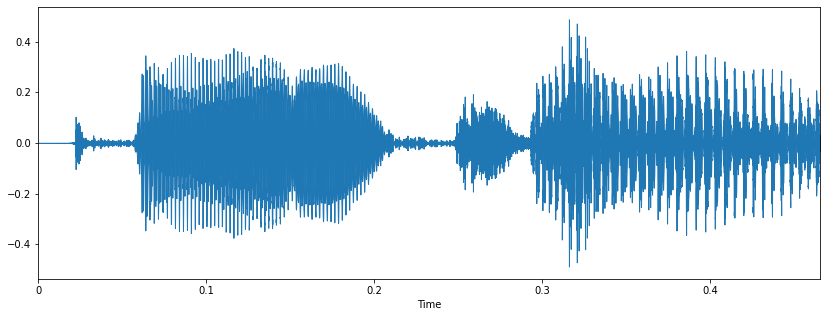

In [16]:
voices=load_voices_files(['dataset/train/LJ001-0001.wav'])
voices = np.array(voices)/(65536/2)
voices = voices[0][:10*1024]
plt.figure(figsize=(14, 5))
librosa.display.waveplot(voices, sr=22000)
ipd.Audio(voices, rate=22000)

voices.shape: (1, 212893)
received 1 k
received 2 k
received 3 k
received 4 k
received 5 k
collect done!
generation done!
voices received!


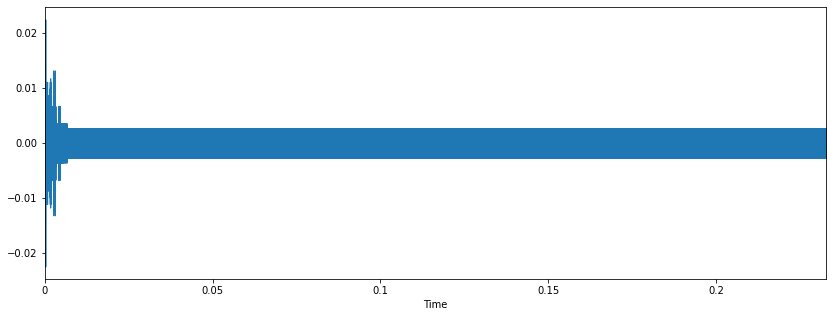

In [30]:

import librosa.display
from multiprocessing import Queue, Process
# from torch.multiprocessing import Pool, Process, set_start_method

voices = load_voices_files(['dataset/train/LJ001-0001.wav'])
voices = np.array(voices)/(65536/2)
print('voices.shape:', voices.shape)
leading_voices = [voices[0][:1024*2]]
context = torch.rand(1, 1024*5, 768).to(torch.device("cuda:0"))
sample_queue = Queue(10)
voice_queue = Queue()

def collect():
  voices = None
  while True:
      sample = sample_queue.get(True)
      if sample is None:
          voice_queue.put(voices, True)
          print("collect done!")
          return
      
      # print("received sample")
      if voices is None:
          voices = sample
      else:
          voices = np.concatenate((voices, sample), axis=1)
      if voices.shape[1] % 1024 == 0:
          print('received %d k' % (voices.shape[1]//1024))

collect_process = Process(target=collect)
collect_process.start()

with torch.no_grad():
    model.generate(leading_voices, context[:, :, :], sample_queue)

# collect_process.join()
voices = voice_queue.get(True)
print("voices received!")
x = voices[0] 
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=22000)
ipd.Audio(x, rate=22000)


In [ ]:
print(x[100:200])
print(np.min(x))